# Project: Stanford Dog Breed Classifier

**Description:**

Hello and welcome to my Stanford Dog Breed Classifier project! My goal is to find the best performing pre-trained model for classifying dog breeds in order to deploy a reliable dog breed classifier on the cloud.

I will be using a couple of pre-trained models with similar size and performance in keras, including:

- InceptionV3
- EfficientNet

I will evaluate the performance of each model on a held-out test set and select the model with the best performance.

Once I have selected the best model, I will deploy it on the cloud so that it can be used to classify dog breeds in real time.


🐶 This project is an exciting journey through a captivating collection of dog images from around the world. The dataset is a treasure trove of adorable doggos!

**Project Highlights:**

- **120 Unique Dog Breeds**: Immerse yourself in a delightful collection of 120 different dog breeds, from elegant poodles to charming pugs. 🐩

- **A Wealth of Dog Pics**: With a whopping 20,580 dog images, it's like flipping through a photo album packed with furry friends on steroids!

- **Valuable Insights**: Each image comes with essential information, including the dog's breed and precise location within the image (bounding boxes). 📦

**About the Dataset:**

This fantastic dog dataset was put together by some really smart folks, Aditya Khosla and colleagues. They made it for a special task called "Novel dataset for Fine-Grained Image Categorization." they wanted to help computers get really good at telling one dog breed from another.

If you're curious to learn more about the project's origins, you can explore the original reference here: [Stanford Dogs Dataset Reference](http://vision.stanford.edu/aditya86/ImageNetDogs). It's a treasure trove of interesting insights!

"This project demonstrates my skills in working with complex data, understanding detailed image categories, and adding helpful annotations. It highlights my ability to process images and handle different types of data effectively. During this project, I faced and overcame various challenges by using advanced methods, which greatly contributed to my learning in the field of machine learning." 🌟

## 1. Dog Breed Dataset

### 1.1. Downloading the dataset

The dataset consists of two main folders:

- **Images:** This folder contains 20,580 images of dogs belonging to 120 species. The images are divided into 120 folders, one for each breed.

- **Annotations:** This folder contains 20,580 XML files divided into 120 folders, one for each dog image. Each XML file contains basic information of the corresponding image, such as the filename, the width and height of the image, and the class label. It also contains information about the bounding box of the dog in the image.

In [1]:
import os
import requests
import tarfile

def download_and_extract_tar(url: str,
                             save_path: str,
                             extract_path: str) -> None:
    """
    Download and extract a TAR file from a given URL.

    Args:
        url (str): The URL to download the TAR file from.
        save_path (str): The directory where the TAR file will be saved.
        extract_path (str): The directory where the contents of the TAR file will be extracted.

    Returns:
        None
    """
    file_name = url.split('/')[-1]

    # Check if the extraction directory already exists
    if os.path.exists('Images') and os.path.exists('Annotation'):
        print(f"[INFO] {file_name} already exists. Skipping downloading it...")
        return

    # Downloading the TAR file
    print(f"[INFO] Downloading '{file_name}' file.")
    response = requests.get(url)
    tar_file_path = os.path.join(save_path, file_name)
    with open(tar_file_path, "wb") as f:
        f.write(response.content)
    print(f"[INFO] '{file_name}' file downloaded successfully!")

    # Extract the contents of the TAR file
    with tarfile.open(tar_file_path, "r") as tarf:
        tarf.extractall(extract_path)
    print(f"[INFO] '{file_name}' file extracted successfully!")

    # Remove the TAR file
    os.remove(tar_file_path)
    print(f"[INFO] '{file_name}' file removed.")

In [2]:
# Downloading images.tar file
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
save_path = "./"  # Path to save the TAR file
extract_path = "./"  # Path to extract the TAR file contents

download_and_extract_tar(url, save_path, extract_path)

# Downloading annotation.tar file
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
save_path = "./"  # Path to save the TAR file
extract_path = "./"  # Path to extract the TAR file contents

download_and_extract_tar(url, save_path, extract_path)

[INFO] Downloading 'images.tar' file.
[INFO] 'images.tar' file downloaded successfully!
[INFO] 'images.tar' file extracted successfully!
[INFO] 'images.tar' file removed.
[INFO] Downloading 'annotation.tar' file.
[INFO] 'annotation.tar' file downloaded successfully!
[INFO] 'annotation.tar' file extracted successfully!
[INFO] 'annotation.tar' file removed.


### 1.2. Cropping and Copying the Dataset

To train our models, we first need to crop each image using the bounding box provided in the XML file. This will ensure that the model only sees the dog in the image, and not any of the background.

Once the images have been cropped, we need to split the dataset into three parts: training, validation, and test. The training set will be used to train the model, the validation set will be used to evaluate the performance of the model during training, and the test set will be used to evaluate the performance of the model after training is complete.

In [3]:
import os
from PIL import Image
import xml.etree.ElementTree as ET

def crop_and_copy_images(images_dir: str, annotations_dir: str, output_dir: str) -> None:
    """
    Crop and copy images based on XML annotations to a specified output directory.

    Args:
        images_dir (str): The directory containing the original images.
        annotations_dir (str): The directory containing XML annotations.
        output_dir (str): The directory where cropped images will be saved.

    Returns:
        None
    """
    # Check if the provided paths exist
    if not os.path.exists(images_dir):
        print(f"Images directory '{images_dir}' does not exist.")
        return
    if not os.path.exists(annotations_dir):
        print(f"Annotations directory '{annotations_dir}' does not exist.")
        return
    if not os.path.exists(output_dir):
        print(f"Creating output directory '{output_dir}'.")
        os.makedirs(output_dir, exist_ok=True)

    print("[INFO] Processing images. Please wait...")
    for root, dirs, files in os.walk(annotations_dir):
        for file in files:
            annotation_path = os.path.join(root, file)
            class_folder = os.path.basename(root)
            class_name = class_folder.split("-", 1)[1].capitalize() # Extract only the class name
            image_dir = os.path.basename(root)
            image_name = file + ".jpg"
            image_path = os.path.join(images_dir, image_dir, image_name)

            # Check if the image file exists
            if not os.path.exists(image_path):
                print(f"Image file '{image_path}' does not exist.")
                continue

            # Parse the annotation XML file
            with open(annotation_path, 'r') as f:
                annotation_content = f.read()
            annotation_root = ET.fromstring(annotation_content)
            object_elem = annotation_root.find("object")
            bndbox_elem = object_elem.find("bndbox")
            xmin = int(bndbox_elem.find("xmin").text)
            ymin = int(bndbox_elem.find("ymin").text)
            xmax = int(bndbox_elem.find("xmax").text)
            ymax = int(bndbox_elem.find("ymax").text)

            # Crop and save the image
            with Image.open(image_path) as image:
                cropped_image = image.crop((xmin, ymin, xmax, ymax)).convert("RGB")
            output_folder = os.path.join(output_dir, class_name)
            os.makedirs(output_folder, exist_ok=True)
            output_path = os.path.join(output_folder, image_name)
            cropped_image.save(output_path)

    print("[INFO] Done.")

In [4]:
# Paths to dataset folders
images_dir = "./Images"
annotations_dir = "./Annotation"
output_dir = "./cropped_images"

crop_and_copy_images(images_dir, annotations_dir, output_dir)

Creating output directory './cropped_images'.
[INFO] Processing images. Please wait...
[INFO] Done.


### 1.3. Creating Training, Validation and Test sets

In [7]:
import os
import random
import shutil
from typing import Tuple

def split_dataset(cropped_images_dir: str,
                  train_dir: str,
                  val_dir: str,
                  test_dir: str,
                  split_ratio: Tuple[float, float, float]=(0.8, 0.1, 0.1),
                  seed: int=42) -> None:
    """
    Split a dataset of cropped images into train, validation, and test sets based on a given split ratio.

    Args:
        cropped_images_dir (str): The directory containing cropped images.
        train_dir (str): The directory where the train set will be saved.
        val_dir (str): The directory where the validation set will be saved.
        test_dir (str): The directory where the test set will be saved.
        split_ratio (tuple): A tuple representing the ratio of train, validation, and test data. Default is (0.8, 0.1, 0.1).
        seed (int): Random seed for shuffling the images. Default is 42.

    Returns:
        None
    """

    # Check if the provided paths exist
    if not os.path.exists(cropped_images_dir):
        print(f"[INFO] Cropped images directory '{cropped_images_dir}' does not exist.")
        return
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # Iterate through each class folder
    class_folders = os.listdir(cropped_images_dir)
    for class_folder in class_folders:
        class_dir = os.path.join(cropped_images_dir, class_folder)

        # Get the list of images in the class folder and shuffle them randomly
        image_files = os.listdir(class_dir)

        random.seed(seed)
        random.shuffle(image_files)

        # Calculate the number of images for each split
        num_images = len(image_files)
        num_train = int(num_images * split_ratio[0])
        num_val = int(num_images * split_ratio[1])
        num_test = num_images - num_train - num_val

        # Split the images into train, validation, and test sets
        train_images = image_files[:num_train]
        val_images = image_files[num_train:num_train+num_val]
        test_images = image_files[num_train+num_val:]

        # Create class folders within train, validation, and test directories
        train_class_dir = os.path.join('data', train_dir, class_folder)
        val_class_dir = os.path.join('data', val_dir, class_folder)
        test_class_dir = os.path.join('data', test_dir, class_folder)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Copy images to respective split folders
        for image_name in train_images:
            src_path = os.path.join(class_dir, image_name)
            dst_path = os.path.join(train_class_dir, image_name)
            shutil.copy(src_path, dst_path)

        for image_name in val_images:
            src_path = os.path.join(class_dir, image_name)
            dst_path = os.path.join(val_class_dir, image_name)
            shutil.copy(src_path, dst_path)

        for image_name in test_images:
            src_path = os.path.join(class_dir, image_name)
            dst_path = os.path.join(test_class_dir, image_name)
            shutil.copy(src_path, dst_path)

    print("[INFO] Dataset split completed.")

In [8]:
# Path to your cropped images
cropped_images_dir = "./cropped_images"

# Paths to dataset splits
train_dir = "Train"
val_dir = "Validation"
test_dir = "Test"

split_dataset(cropped_images_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.1, 0.1))

[INFO] Dataset split completed.


I have created a .zip file to store the data and make the results reproducible. This ensures that the data is not corrupted and that the results can be easily reproduced by others.

The .zip file contains a `data` folder with the following subfolders:

* `Train`: This folder contains the training images.
* `Validation`: This folder contains the validation images.
* `Test`: This folder contains the test images.

You can download the .zip file in the section 1.6.

In [9]:
# Deleting created folder
# !rm -rf cropped_images Train Validation Test

### 1.4. Recovering Train, Validation, and Test Folders


In [11]:
import os
import gdown
import zipfile
from typing import Optional

def download_and_extract(url: str, file_name: str, output_folder: str = 'data') -> None:
    """
    Download a zip file from the specified URL, extract its contents, and delete the zip file.

    Args:
        url (str): The URL of the zip file to download.
        file_name (str): The name to save the downloaded zip file as.
        output_folder (str, optional): The folder where the contents of the zip file will be extracted.
                                      Defaults to 'data'.

    Returns:
        None
    """
    # Check if the output folder already exists
    if os.path.exists(output_folder):
        print(f"[INFO] '{output_folder}' already exists. Skipping downloading.")
        return

    # Download the file using gdown
    gdown.download(url=url, output=file_name, quiet=False, fuzzy=True)

    print(f"[INFO] '{file_name}' file downloaded successfully.")

    # Extract the content
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

    print(f"[INFO] '{file_name}' file extracted successfully.")

    # Delete the zip file
    os.remove(file_name)
    print("[INFO] Deleting Zip file.")


In [12]:
# Downloading dataset
url = "https://drive.google.com/file/d/1f-AKGCcA5nKTaEyTys-vTZmeW3PPNH3U/view?usp=sharing"
file_name = 'dataset.zip'

download_and_extract(url, file_name, output_folder='data')

Downloading...
From: https://drive.google.com/uc?id=1f-AKGCcA5nKTaEyTys-vTZmeW3PPNH3U
To: /content/dataset.zip
100%|██████████| 409M/409M [00:04<00:00, 93.2MB/s]


[INFO] 'dataset.zip' file downloaded successfully.
[INFO] 'dataset.zip' file extracted successfully.
[INFO] Deleting Zip file.


### 1.5. Visualizing Some Examples

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_dir_images(folder_path: str, n_to_show: int = 8):
    """
    Display a specified number of images from a folder of a randomly selected breed.

    Args:
        folder_path (str): The path to the folder containing subdirectories of images.
        n_to_show (int): The number of images to display.

    Returns:
        None
    """
    # Pick a random breed name from the available subdirectories
    breed_name = random.sample(os.listdir(folder_path), k=1)[0]
    # Print the name of the selected breed
    print(f"Selected Breed: {breed_name}")

    img_dir = os.path.join(folder_path, breed_name)
    images = os.listdir(img_dir)[:n_to_show]

    if not images:
        print(f"No images found for '{breed_name}' in '{folder_path}'.")
        return

    plt.figure(figsize=(10, 10))
    for i in range(n_to_show):
        img = mpimg.imread(os.path.join(img_dir, images[i]))
        plt.subplot((n_to_show + 3) // 4, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

Selected Breed: Curly-coated_retriever


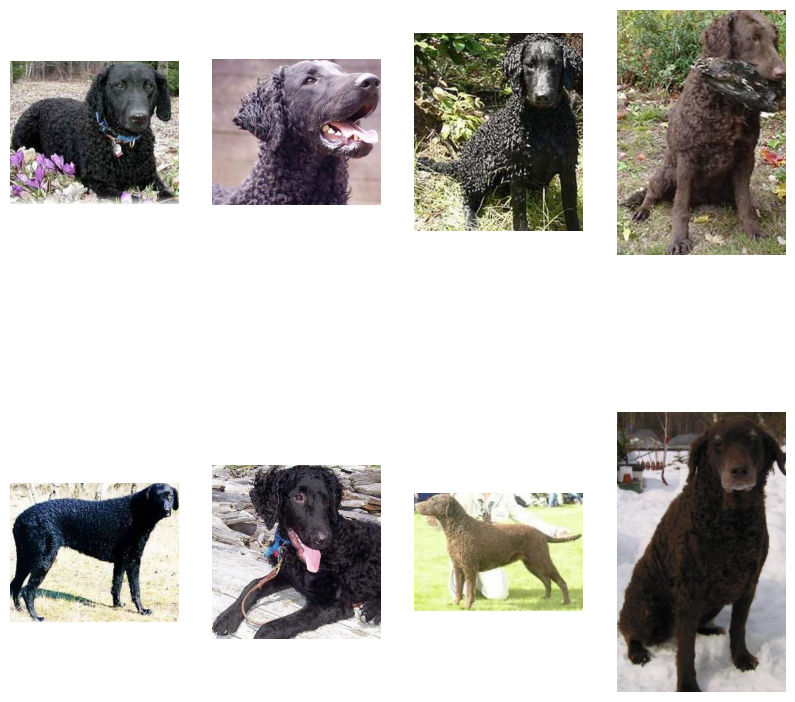

In [14]:
# Show n number images of a breed at a time
show_dir_images(folder_path='data/Train', n_to_show=8)

### 1.6. Verifying the Dataset

In [15]:
import os
from typing import Tuple

def count_dataset(train_dir: str, val_dir: str, test_dir: str) -> None:
    """
    Count the number of classes and images in each directory and print the statistics.

    Args:
        train_dir (str): Path to the train directory.
        val_dir (str): Path to the validation directory.
        test_dir (str): Path to the test directory.

    Returns:
        None
    """
    # Check if the provided paths exist
    if not os.path.exists(train_dir):
        print(f"Train directory '{train_dir}' does not exist.")
        return
    if not os.path.exists(val_dir):
        print(f"Validation directory '{val_dir}' does not exist.")
        return
    if not os.path.exists(test_dir):
        print(f"Test directory '{test_dir}' does not exist.")
        return

    # List the classes in each directory
    train_classes = os.listdir(train_dir)
    val_classes = os.listdir(val_dir)
    test_classes = os.listdir(test_dir)

    # Print a table header
    print(f"{'-'*60}")
    print("| Class Folder                   | Train | Validation | Test |")
    print(f"{'-'*60}")

    # Iterate through each class folder in the train directory
    for class_folder in train_classes:
        class_dir = os.path.join(train_dir, class_folder)
        if os.path.isdir(class_dir):
            count_train = len(os.listdir(class_dir))
        else:
            count_train = 0

        # Initialize counts for validation and test
        val_count = 0
        test_count = 0

        # Check if the class folder exists in the validation directory
        if class_folder in val_classes:
            val_class_dir = os.path.join(val_dir, class_folder)
            if os.path.isdir(val_class_dir):
                val_count = len(os.listdir(val_class_dir))

        # Check if the class folder exists in the test directory
        if class_folder in test_classes:
            test_class_dir = os.path.join(test_dir, class_folder)
            if os.path.isdir(test_class_dir):
                test_count = len(os.listdir(test_class_dir))

        # Print class-wise counts in the table
        print(f"| {class_folder:<30} | {count_train:<5} | {val_count:<5}  | {test_count:<5} |")

    # Print a table footer
    print(f"{'-'*60}")

    # Calculate and print the total counts
    total_classes = len(train_classes)
    train_total_images = sum([len(os.listdir(os.path.join(train_dir, class_folder))) for class_folder in train_classes])
    validation_total_images = sum([len(os.listdir(os.path.join(val_dir, class_folder))) for class_folder in val_classes])
    test_total_images = sum([len(os.listdir(os.path.join(test_dir, class_folder))) for class_folder in test_classes])

    print(f"| Total images                   | {train_total_images:<5} | {validation_total_images:<5}  | {test_total_images:<5} |")
    print(f"{'-'*60}")

    # Print total class count
    print()
    print(f"Total classes: {total_classes}")
    print(f"Total images (Overall): {train_total_images + validation_total_images + test_total_images}")

In [16]:
# Provide the paths to train, validation, and test directories
train_dir = "./data/Train"
val_dir = "./data/Validation"
test_dir = "./data/Test"

# Call the function to count the dataset
count_dataset(train_dir, val_dir, test_dir)

------------------------------------------------------------
| Class Folder                   | Train | Validation | Test |
------------------------------------------------------------
| Papillon                       | 156   | 19     | 21    |
| Rhodesian_ridgeback            | 137   | 17     | 18    |
| Dandie_dinmont                 | 144   | 18     | 18    |
| Irish_wolfhound                | 174   | 21     | 23    |
| Cairn                          | 157   | 19     | 21    |
| Chihuahua                      | 121   | 15     | 16    |
| Old_english_sheepdog           | 135   | 16     | 18    |
| American_staffordshire_terrier | 131   | 16     | 17    |
| Otterhound                     | 120   | 15     | 16    |
| Greater_swiss_mountain_dog     | 134   | 16     | 18    |
| Australian_terrier             | 156   | 19     | 21    |
| Norwegian_elkhound             | 156   | 19     | 21    |
| Welsh_springer_spaniel         | 120   | 15     | 15    |
| Bloodhound                     | 

## 2. Experimenting with `InceptionV3`

### 2.1. Instanciate `InceptionV3` Model

To use transfer learning, we need to load the pre-trained weights of the `InceptionV3` model. We can do this using the `tensorflow.keras.applications` module.

Once the weights have been loaded, we need to freeze the existing layers. This is done by setting the `trainable` attribute of the layers to `False`. This will prevent the layers from being updated during training.

We also need to get a reference to the last layer of the model. This is the layer that will output the features of the images in order to give a class

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from typing import Tuple, Union

def build_custom_model(model_name: str,
                       input_shape: Tuple[int, int, int],
                       hidden_units: int = 1024,
                       output_units: int = 120,
                       dropout: float = 0.2,
                       trainable: bool = False,
                       seed: int = 42) -> Tuple[tf.keras.Model, callable]:
    """
    Build a custom deep learning model based on the specified architecture.

    Args:
        model_name (str): Name of the base model architecture.
        input_shape (Tuple[int, int, int]): Input shape for the model's images.
        hidden_units (int): Number of units in the hidden fully connected layer.
        output_units (int): Number of output units for classification.
        dropout (float): Dropout rate for regularization.
        trainable (bool): Whether to make the base model's layers trainable.
        seed (int): Random seed for TensorFlow operations. Default is 42.

    Returns:
        Tuple[tf.keras.Model, callable]: A tuple containing the custom built model and a preprocessing function.

    Raises:
        ValueError: If an unsupported model_name is provided.
    """

    assert model_name in ('InceptionV3', 'EfficientNetV2S'), "'model_name' must be 'InceptionV3' or 'EfficientNetV2S'"

    # Set seeds
    tf.random.set_seed(seed)

    # Instantiate the base model
    if model_name == 'InceptionV3':
        from tensorflow.keras.applications import InceptionV3
        from tensorflow.keras.applications.inception_v3 import preprocess_input

        base_model = InceptionV3(input_shape=input_shape,
                                 include_top=False,
                                 weights='imagenet')

    elif model_name == 'EfficientNetV2S':
        from tensorflow.keras.applications import EfficientNetV2S
        from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

        base_model = EfficientNetV2S(input_shape=input_shape,
                                     include_top=False,
                                     weights='imagenet')

    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = trainable

    print(f"[INFO] Creating '{model_name}' model instance")
    # Create new model on top
    inputs = Input(shape=input_shape)
    x = base_model(inputs)

    # Convert features of the base model to vectors
    x = GlobalAveragePooling2D()(x)

    # Apply dropout for regularization
    x = Dropout(dropout)(x)

    # Add a fully connected hidden layer with ReLU activation
    x = Dense(hidden_units, activation="relu")(x)

    # Add a final output layer with softmax activation for classification
    outputs = Dense(output_units, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model, preprocess_input

In [22]:
INPUT_SHAPE = (299, 299, 3)
TARGET_SIZE = INPUT_SHAPE[:-1]
BATCH_SIZE = 32
MODEL_NAME = 'InceptionV3'

inception, inception_preprocess_input = build_custom_model(model_name=MODEL_NAME, input_shape=INPUT_SHAPE, seed=42)

[INFO] Creating 'InceptionV3' model instance


In [23]:
inception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 120)               123000    
                                                           

### 2.2. Creating Data Generator for Training and Validation Sets

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Tuple

def create_data_generators(train_dir: str,
                           validation_dir: str,
                           test_dir: str,
                           batch_size: int,
                           target_size: Tuple[int, int],
                           preprocess_input: callable=None,
                           augmentations: dict = None) -> Tuple[tf.keras.utils.Sequence, tf.keras.utils.Sequence, tf.keras.utils.Sequence]:
    """
    Create data generators for training, validation, and testing.

    Args:
        train_dir (str): Path to the training data directory.
        validation_dir (str): Path to the validation data directory.
        test_dir (str): Path to the test data directory.
        batch_size (int): Batch size for data generators.
        target_size (Tuple[int, int]): Target size (height, width) for input images.
        preprocess_input (callable): Preprocessing function for input images.
        augmentations (dict): Optional dictionary of augmentations for the training data generator.

    Returns:
        Tuple[tf.keras.utils.Sequence, tf.keras.utils.Sequence, tf.keras.utils.Sequence]:
            A tuple containing the training data generator, validation data generator, and test data generator.
    """
    # Create data generators with or without augmentation
    if augmentations is not None:
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, **augmentations)
    else:
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Training data generator
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        target_size=target_size,
                                                        shuffle=True  # Shuffle the data for training
                                                        )

    # Validation data generator
    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  target_size=target_size,
                                                                  shuffle=False  # Do not shuffle validation data
                                                                  )

    # Test data generator
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      target_size=target_size,
                                                      shuffle=False  # Do not shuffle test data
                                                      )

    return train_generator, validation_generator, test_generator

In [25]:
TRAINING_DIR = 'data/Train'
VALIDATION_DIR = 'data/Validation'
TEST_DIR = 'data/Test'
TARGET_SIZE = (299,299)
BATCH_SIZE = 32

train_gen, val_gen, _ = create_data_generators(TRAINING_DIR,
                                               VALIDATION_DIR,
                                               TEST_DIR,
                                               BATCH_SIZE,
                                               TARGET_SIZE,
                                               preprocess_input=inception_preprocess_input,
                                               augmentations=None)

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.


### 2.3. Training the Model

We will train the model without data augmentation in order to get a fast result. Data augmentation improve the performance of the model, but it can also make the training process slower.

In this section, we are trying to get a quick result, so we will not use data augmentation. We will train the model for 10 epochs then we will pick the model with the best performance and train it with data augmentation.

In [29]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(model, train_generator, validation_generator, epochs):
    """
    Train a deep learning model on a given dataset.

    Args:
        model (tf.keras.Model): The model to be trained.
        train_generator (tf.keras.utils.Sequence): The training data generator.
        validation_generator (tf.keras.utils.Sequence): The validation data generator.
        epochs (int): The number of training epochs.

    Returns:
        tf.keras.History: The training history containing loss and metric values.
    """
    # Define the Categorical Crossentropy loss with label smoothing
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    # Compile the model with the Adam optimizer and specified learning rate
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss, metrics=["acc"])

    # Train the model
    history = model.fit(train_generator, validation_data=validation_generator,
                        epochs=epochs, verbose=1)

    return history

In [30]:
history_inception = train_model(inception, train_gen, val_gen, epochs=10)

Epoch 1/10
514/514 [==============================] - 109s 184ms/step - loss: 1.8633 - acc: 0.7768 - val_loss: 1.1524 - val_acc: 0.9074
Epoch 2/10
514/514 [==============================] - 80s 155ms/step - loss: 1.1344 - acc: 0.9094 - val_loss: 1.1242 - val_acc: 0.9109
Epoch 3/10
514/514 [==============================] - 79s 154ms/step - loss: 1.0929 - acc: 0.9235 - val_loss: 1.1067 - val_acc: 0.9194
Epoch 4/10
514/514 [==============================] - 79s 154ms/step - loss: 1.0676 - acc: 0.9298 - val_loss: 1.1004 - val_acc: 0.9109
Epoch 5/10
514/514 [==============================] - 78s 153ms/step - loss: 1.0497 - acc: 0.9359 - val_loss: 1.1014 - val_acc: 0.9114
Epoch 6/10
514/514 [==============================] - 78s 151ms/step - loss: 1.0307 - acc: 0.9423 - val_loss: 1.1019 - val_acc: 0.9079
Epoch 7/10
514/514 [==============================] - 77s 150ms/step - loss: 1.0165 - acc: 0.9466 - val_loss: 1.1030 - val_acc: 0.9099
Epoch 8/10
514/514 [==============================] - 

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import History

def plot_loss_acc(history: History):
    """
    Plots the training and validation loss and accuracy from a history object.

    Args:
        history (History): The training dictionary containing loss and metric values.
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Create a subplot with 1 row and 2 columns
    plt.figure(figsize=(8, 4))

    # Subplot 1 (Left)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 2 (Right)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()

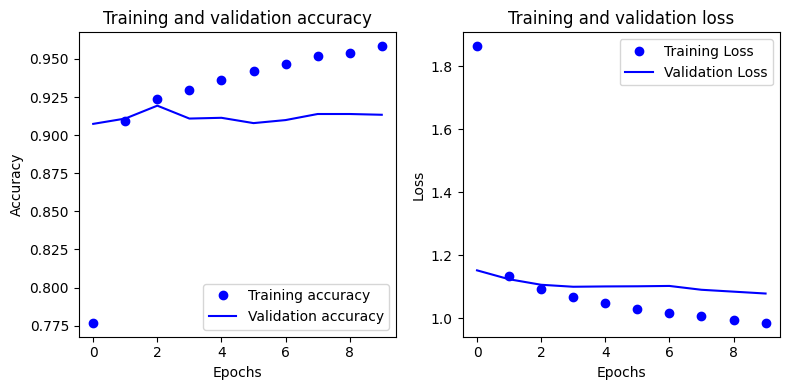

In [32]:
# Plot training results
plot_loss_acc(history_inception)

## 3. Experimenting with `EfficientNetV2S`

### 3.1. Instanciate `EfficientNetV2S` Model

In [34]:
INPUT_SHAPE = (299, 299, 3)
MODEL_NAME = 'EfficientNetV2S'

effnet, effnet_preprocess_input = build_custom_model(model_name=MODEL_NAME, input_shape=INPUT_SHAPE)

82420632/82420632 [==============================] - 1s 0us/step
[INFO] Creating 'EfficientNetV2S' model instance


### 3.2. Creating Data Generator for Training and Validation Sets

In [35]:
TRAINING_DIR = 'data/Train'
VALIDATION_DIR = 'data/Validation'
TEST_DIR = 'data/Test'
BATCH_SIZE = 32
INPUT_SHAPE = (299, 299, 3)
TARGET_SIZE = INPUT_SHAPE[:-1]

train_gen, val_gen, _ = create_data_generators(TRAINING_DIR,
                                                      VALIDATION_DIR,
                                                      TEST_DIR,
                                                      BATCH_SIZE,
                                                      TARGET_SIZE,
                                                      preprocess_input=effnet_preprocess_input,
                                                      augmentations=None)

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.


### 3.3. Training the Model

In [36]:
# Train the model
history_effnet = train_model(effnet, train_gen, val_gen, epochs=10)

Epoch 1/10
514/514 [==============================] - 168s 293ms/step - loss: 2.0580 - acc: 0.8136 - val_loss: 1.0511 - val_acc: 0.9303
Epoch 2/10
514/514 [==============================] - 138s 268ms/step - loss: 1.0698 - acc: 0.9237 - val_loss: 1.0331 - val_acc: 0.9313
Epoch 3/10
514/514 [==============================] - 144s 281ms/step - loss: 1.0422 - acc: 0.9276 - val_loss: 1.0225 - val_acc: 0.9308
Epoch 4/10
514/514 [==============================] - 138s 268ms/step - loss: 1.0275 - acc: 0.9317 - val_loss: 1.0157 - val_acc: 0.9338
Epoch 5/10
514/514 [==============================] - 137s 267ms/step - loss: 1.0133 - acc: 0.9363 - val_loss: 1.0119 - val_acc: 0.9303
Epoch 6/10
514/514 [==============================] - 137s 267ms/step - loss: 1.0027 - acc: 0.9392 - val_loss: 1.0113 - val_acc: 0.9293
Epoch 7/10
514/514 [==============================] - 138s 268ms/step - loss: 0.9951 - acc: 0.9413 - val_loss: 1.0103 - val_acc: 0.9308
Epoch 8/10
514/514 [============================

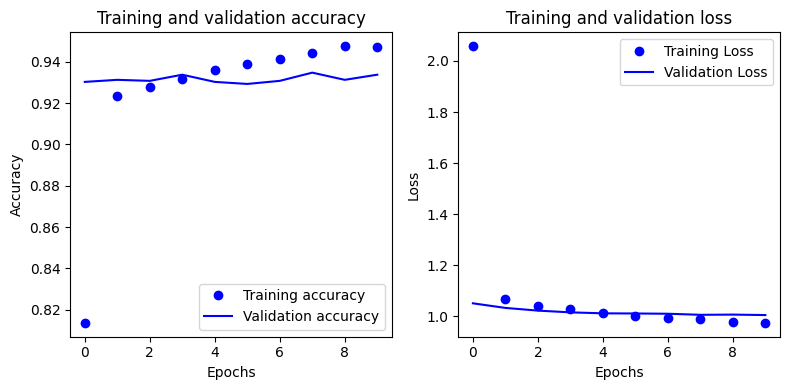

In [37]:
# Plot training results
plot_loss_acc(history_effnet)

## 4. Training with Data Augmentation

We have seen that the `EfficientNetV2S` model has the best performance without data augmentation. Now, we will train the model with data augmentation to see if we can improve its performance.

However, we need to be careful about the type of data augmentation that we use. Since the images are cropped, the image of the dogs are focused. If we use data augmentations like rotation, width shift, height shift, shear, or zoom, we could take a big portion of the dog out of the images. This will not improve the performance of the model.

Instead, we will use data augmentations that are less likely to affect the dog's appearance, such as:

- **Horizontal flip**: This flips the image horizontally.

- **Shear**: This applies a shear transformation to the image, which can slightly distort the image.

We will train the model for 10 epochs with data augmentation and evaluate its performance on the test set. We will then compare the performance of the model with and without data augmentation to see if data augmentation has improved the performance of the model.

In [38]:
TRAINING_DIR = "./data/Train"
VALIDATION_DIR = "./data/Validation"
TEST_DIR = "./data/Test"
BATCH_SIZE = 32
INPUT_SHAPE = (299,299,3)
TARGET_SIZE = (299, 299)

MODEL_NAME = 'EfficientNetV2S'
effnet, effnet_preprocess_input = build_custom_model(model_name=MODEL_NAME, input_shape=INPUT_SHAPE)

# Data augmentations
augmentations = {'horizontal_flip': True,
                 'shear_range': 0.2}

print()

# Data generator
train_gen, val_gen, test_gen = create_data_generators(TRAINING_DIR,
                                               VALIDATION_DIR,
                                               TEST_DIR,
                                               BATCH_SIZE,
                                               TARGET_SIZE,
                                               preprocess_input=effnet_preprocess_input,
                                               augmentations=augmentations)

history_effnet = train_model(effnet, train_gen, val_gen, epochs=10)

[INFO] Creating 'EfficientNetV2S' model instance

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.
Epoch 1/10
514/514 [==============================] - 395s 739ms/step - loss: 2.0662 - acc: 0.8165 - val_loss: 1.0538 - val_acc: 0.9248
Epoch 2/10
514/514 [==============================] - 374s 728ms/step - loss: 1.0722 - acc: 0.9215 - val_loss: 1.0334 - val_acc: 0.9338
Epoch 3/10
514/514 [==============================] - 375s 729ms/step - loss: 1.0425 - acc: 0.9278 - val_loss: 1.0228 - val_acc: 0.9333
Epoch 4/10
514/514 [==============================] - 375s 730ms/step - loss: 1.0266 - acc: 0.9325 - val_loss: 1.0203 - val_acc: 0.9298
Epoch 5/10
514/514 [==============================] - 374s 728ms/step - loss: 1.0146 - acc: 0.9349 - val_loss: 1.0182 - val_acc: 0.9293
Epoch 6/10
514/514 [==============================] - 375s 729ms/step - loss: 1.0070 - acc: 0.9376 - val_loss: 1.0150 - val_acc: 0.9268
E

## 5. Final Testing

The following code snippet for image prediction and storage was adapted from code originally available for PyTorch [here](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them). The original code was refactored and adapted to work with TensorFlow.

In [41]:
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: tf.keras.Model,
                   preprocess_function,
                   class_names: List[str]) -> List[Dict]:
    """
    Predict class labels for a list of image paths using a given model.

    Args:
        paths (List[pathlib.Path]): List of image file paths.
        model (tf.keras.Model): The trained model for image classification.
        preprocess_function: A preprocessing function specific to the model.
        class_names (List[str]): List of class names for mapping predictions.

    Returns:
        List[Dict]: A list of dictionaries with prediction details.

    Each dictionary contains the following information:
    - 'image_path': The path to the image file.
    - 'class_name': The true class name.
    - 'time_for_pred': Time taken for prediction (in seconds).
    - 'pred_prob': Maximum prediction probability.
    - 'pred_class': Predicted class name.
    - 'correct': Boolean indicating whether the prediction is correct.
    """

    # Create an empty list to store prediction dictionaries
    pred_list = []

    # Loop through target paths
    for path in tqdm(paths):
        # Create an empty dictionary to store prediction information for each sample
        pred_dict = {}

        # Get the sample path and ground truth class name
        pred_dict["image_path"] = str(path)  # Convert the Path object to a string
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Start the prediction timer
        start_time = timer()

        # Load the image
        img = load_img(path, target_size=(299, 299))

        # Preprocess the image using the provided preprocess_function
        preprocessed_img = preprocess_function(img)

        # Make predictions using your model
        predictions = model.predict(tf.expand_dims(preprocessed_img, axis=0), verbose=0)
        pred_prob = tf.nn.softmax(predictions[0])
        pred_label = tf.argmax(predictions[0])
        pred_class = class_names[pred_label.numpy()]

        # End the timer and calculate time per prediction
        end_time = timer()
        pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        # Store prediction details in the dictionary
        pred_dict["pred_prob"] = round(pred_prob.numpy().max(), 4)
        pred_dict["pred_class"] = pred_class

        # Check if the prediction matches the true label
        pred_dict["correct"] = class_name == pred_class

        # Add the dictionary to the list of predictions
        pred_list.append(pred_dict)

    # Return the list of prediction dictionaries
    return pred_list

In [42]:
from pathlib import Path

# Define the name of classes from train generator
class_names = list(train_gen.class_indices.keys())

# Make predictions across the test dataset with EffNet
test_data_paths = list(Path('data/Test').glob('*/*.jpg'))  # Convert to list for tqdm compatibility

pred_prob = pred_and_store(paths=test_data_paths,
                           model=effnet,
                           preprocess_function=effnet_preprocess_input,
                           class_names=class_names)

  0%|          | 0/2153 [00:00<?, ?it/s]

In [43]:
import pandas as pd

df = pd.DataFrame(pred_prob)

In [44]:
df.sample(5)

,image_path,class_name,time_for_pred,pred_prob,pred_class,correct
443,data/Test/Toy_terrier/n02087046_1520.jpg,Toy_terrier,0.2210,0.0201,Toy_terrier,True
631,data/Test/Kelpie/n02105412_7810.jpg,Kelpie,0.0749,0.0211,Kelpie,True
1220,data/Test/Boston_bull/n02096585_7887.jpg,Boston_bull,0.0820,0.0211,Boston_bull,True
2016,data/Test/Giant_schnauzer/n02097130_2989.jpg,Giant_schnauzer,0.0814,0.0210,Giant_schnauzer,True
744,data/Test/English_springer/n02102040_97.jpg,English_springer,0.0802,0.0193,English_springer,True


### 5.1. Evaluating the Models

The models can be evaluated using the following metrics:

- **Accuracy**: This is the percentage of images

- **Precision**: This is the percentage of images

- **Recall**: This is the percentage of positive images

- **f1-score**:


In [45]:
# Accuracy on Test dataset
df.correct.sum()/len(df)

0.9372967951695309

In [47]:
from sklearn.metrics import classification_report

print(classification_report(df['class_name'], df['pred_class'], target_names=sorted(df['class_name'].unique())))

                                precision    recall  f1-score   support

                 Affenpinscher       1.00      1.00      1.00        15
                  Afghan_hound       0.96      1.00      0.98        25
           African_hunting_dog       1.00      1.00      1.00        18
                      Airedale       0.95      0.95      0.95        21
American_staffordshire_terrier       0.80      0.47      0.59        17
                   Appenzeller       0.81      0.81      0.81        16
            Australian_terrier       0.95      0.90      0.93        21
                       Basenji       1.00      1.00      1.00        22
                        Basset       1.00      1.00      1.00        18
                        Beagle       0.91      1.00      0.95        20
            Bedlington_terrier       1.00      1.00      1.00        19
          Bernese_mountain_dog       0.96      0.96      0.96        23
       Black-and-tan_coonhound       0.94      1.00      0.97  

### 5.2. Ordering Classes by its F1-Score

In [48]:
df_report = pd.DataFrame(classification_report(df['class_name'], df['pred_class'], target_names=sorted(df['class_name'].unique()), output_dict=True)).transpose()

In [60]:
df_report.sort_values(by='f1-score')

,precision,recall,f1-score,support
Eskimo_dog,0.750000,0.200000,0.315789,15.0
Miniature_poodle,0.857143,0.375000,0.521739,16.0
American_staffordshire_terrier,0.800000,0.470588,0.592593,17.0
Siberian_husky,0.642857,0.900000,0.750000,20.0
Staffordshire_bullterrier,0.625000,0.937500,0.750000,16.0
...,...,...,...,...
Papillon,1.000000,1.000000,1.000000,21.0
Pug,1.000000,1.000000,1.000000,20.0
Rottweiler,1.000000,1.000000,1.000000,16.0
German_shepherd,1.000000,1.000000,1.000000,16.0


- **Disparities in performance across classes**

The F1-scores for the different dog breeds vary significantly. The "Siberian_husky" and "Staffordshire_bullterrier" classes have achieved F1-scores of 0.75, indicating that the model performs relatively well in correctly classifying these breeds. This suggests that the model captures distinctive features of these breeds effectively.

On the other hand, the "Eskimo_dog" class has the lowest F1-score at 0.32, implying that the model struggles to classify instances of this breed accurately. This might signal a need for more training data or the inherent similarity of Eskimo Dogs to other breeds, causing confusion for the model.

Several classes, such as "Papillon", "Pug", "Rottweiler", "German_shepherd", and "Japanese_spaniel", achieve perfect F1-scores of 1.0. While this might appear promising, it is essential to investigate further, as perfect scores could indicate overfitting.

## 6. Saving the Best-Performing Model

In [64]:

import zipfile
import os
from typing import List

def save_model_and_create_zip(model: tf.keras.Model, model_path: str, zip_name: str) -> None:
    """
    Save a TensorFlow/Keras model and create a zip archive containing specified directories.

    Args:
        model (tf.keras.Model): The model to be saved. A Keras model instance
        model_path (str): Path to save the model.
        zip_name (str): Name of the zip archive.

    Returns:
        None
    """

    # Define the file path for saving the model
    model_file_path = os.path.join('models', model_path)

    # Save the model to the 'models' directory
    model.save(model_file_path)

    # Create a zip archive
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        # Add the model file to the zip archive
        zipf.write(model_file_path, arcname=os.path.basename(model_file_path))


In [65]:
# Specify the paths
model_path = 'dogg_breed_effnet_augmentation.h5'
zip_name = 'models.zip'

# Save the model and create the zip archive
save_model_and_create_zip(model=effnet, model_path=model_path, zip_name=zip_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. Recovering and Testing the Best Model

In [68]:
url = "https://drive.google.com/file/d/1ln0fdQqskjcmM1F7tyoEs05mtNYG-NMi/view?usp=sharing"
file_name = 'models.zip'
output_folder='models'

download_and_extract(url, file_name, output_folder)

[INFO] 'models' already exists. Skipping downloading.


In [69]:
import tensorflow as tf

# Loading my pre-trained model
model = tf.keras.models.load_model('./models/dogg_breed_effnet_augmentation.h5')

In [70]:
# Testing loaded model so see if there is no issues when saving and loading
from pathlib import Path

class_names = list(test_gen.class_indices.keys())
paths = Path('data/Test').glob('*/*.jpg')

pred_prob = pred_and_store(paths=paths,
                           model=model,
                           preprocess_function=effnet_preprocess_input,
                           class_names=class_names)

0it [00:00, ?it/s]

In [71]:
import pandas as pd

# Caculating accuracy on loaded model
df_pretrained = pd.DataFrame(pred_prob)

df_pretrained['correct'].sum() / len(df_pretrained)

0.9372967951695309

In [ ]:
# Loading in a custom image
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Get the class names
class_names = list(test_gen.class_indices.keys())

uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = effnet_preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    # Make predictions
    images = np.vstack([x])
    predictions = model.predict(images, batch_size=10)
    top_classes_indices = np.argsort(predictions[0])[::-1][:3]  # Get the indices of top 3 classes
    top_classes = [class_names[i] for i in top_classes_indices]  # Get the class names of top 3 classes
    top_probabilities = predictions[0][top_classes_indices] * 100  # Get the probabilities of top 3 classes

    # Print the results
    print("File: " + fn)
    for i in range(3):
        print(f"{top_classes[i]}: {top_probabilities[i]:.2f}%")


Saving Airedale Terrier1.jpg to Airedale Terrier1 (1).jpg
Saving Bluetick-Coonhound.jpg to Bluetick-Coonhound (1).jpg
Saving Corgi.jpg to Corgi (1).jpg
Saving Dalmata.jpg to Dalmata (1).jpg
Saving Goldendoodle_shutterstock_Matthew-Yoder.jpg to Goldendoodle_shutterstock_Matthew-Yoder (1).jpg
Saving Large-Dog-Breeds.png to Large-Dog-Breeds (1).png
Saving pit-bull-featured.jpg to pit-bull-featured (1).jpg
1/1 [==============================] - 3s 3s/step
File: Airedale Terrier1 (1).jpg
Airedale: 89.03%
Otterhound: 2.06%
Wire-haired_fox_terrier: 0.89%
1/1 [==============================] - 0s 36ms/step
File: Bluetick-Coonhound (1).jpg
Bluetick: 90.27%
Entlebucher: 0.58%
Black-and-tan_coonhound: 0.46%
1/1 [==============================] - 0s 37ms/step
File: Corgi (1).jpg
Pembroke: 93.36%
Cardigan: 1.25%
Ibizan_hound: 0.13%
1/1 [==============================] - 0s 39ms/step
File: Dalmata (1).jpg
Kuvasz: 8.92%
English_setter: 7.07%
Great_dane: 2.68%
1/1 [==============================] - 0s

## 8. Model Deployment

The model can be deployed so that it can be used to classify dog breeds in real time. This can be done using a tool like Gradio in Huggingface.

### 8.1. Making an EfficientNetB2 Feature Extractor


In [77]:
import tensorflow

# Load the pre-trained EfficientNetV2 model
effnet = tensorflow.keras.models.load_model('models/dogg_breed_effnet_augmentation.h5')

for layer in effnet.layers:
    layer.trainable = False

# Get the preprocessing function for EfficientNetV2
effnet_preprocess_input = tensorflow.keras.applications.efficientnet_v2.preprocess_input

effnet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 10, 10, 1280)      20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_7 (Dense)             (None, 120)               1230

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = 'data/Train'
VALIDATION_DIR = 'data/Validation'
TEST_DIR = 'data/Test'
INPUT_SHAPE = (299, 299, 3)
TARGET_SIZE = INPUT_SHAPE[:-1]
BATCH_SIZE = 32

train_gen, _, _ = create_data_generators(TRAINING_DIR,
                                                      VALIDATION_DIR,
                                                      TEST_DIR,
                                                      BATCH_SIZE,
                                                      TARGET_SIZE,
                                                      preprocess_input=None,
                                                      augmentations=None)

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.


### 8.2 Creating a Gradio Demo

In [80]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.4 MB/s eta 0

In [81]:
from typing import Tuple, Dict
import tensorflow as tf
import numpy as np
from timeit import default_timer as timer
from PIL import Image

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on an image and returns prediction and time taken.

    Args:
        image_path (str): Path to the input image.

    Returns:
        Tuple[Dict, float]: A tuple containing a dictionary of class labels and prediction probabilities
        and the prediction time.
    """
    # Start the timer
    start_time = timer()

    # Open the image using PIL
    img = img.resize((299, 299))  # Resize the image to the model's expected input size

    # Convert the image to a NumPy array
    x = np.array(img)
    x = effnet_preprocess_input(x)

    # Add a batch dimension
    x = tf.expand_dims(x, axis=0)

    # Pass the image through the model
    predictions = effnet(x)

    top_classes_indices = np.argsort(predictions[0])[::-1][:3]  # Get the indices of top 3 classes
    top_classes = [class_names[i] for i in top_classes_indices]  # Get the class names of top 3 classes
    top_probabilities = [predictions[0][index] for index in top_classes_indices] * 100  # Get the probabilities of top 3 classes

    # Create a dictionary of class labels and prediction probabilities
    pred_labels_and_probs = {top_classes[i]: float(top_probabilities[i]) for i in range(len(top_classes_indices))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time


In [79]:
class_names = list(train_gen.class_indices.keys())

with open('class_names.txt', 'w') as f:
    for names in class_names:
        f.write(names + '\n')

In [86]:
import random
from pathlib import Path
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path('data/Test/').glob("*/*.jpg"))

# Get the name of the classes
with open('class_names.txt') as f:
    class_names = [breed.strip() for breed in f.readlines()]

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/Test/Malamute/n02110063_12514.jpg

Prediction label and probability dictionary: 
{'Siberian_husky': 0.4165765941143036, 'Malamute': 0.3811720609664917, 'Eskimo_dog': 0.10355371236801147}
Prediction time: 0.32814 seconds


### 8.3. Creating a List of Example Images

In [87]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]

### 8.4. Building a Gradio Interface

In [88]:
import gradio as gr

# Create title, description and article strings
title = "Dog Breeds Classifier"
description = "An EfficientNetV2S feature extractor computer vision model to classify images of 120 different breeds."
article = "Created at [GitHub](https://github.com/mygithub)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=False) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


### 8.5. Preparing Every File Needed for Gradio App

In [1]:
!mkdir -p demo/dog_breed_classifier

In [ ]:
!mv class_names.txt demo/dog_breed_classifier/

In [2]:
%%writefile demo/dog_breed_classifier/requirements.txt
gradio==3.43.2
tensorflow==2.13.0

Writing demo/dog_breed_classifier/requirements.txt


In [ ]:
!mkdir -p demo/dog_breed_classifier/examples

In [ ]:
!mv models/dog_breed_effnet_augmentation.h5 demo/dog_breed_classifier/

In [ ]:
import shutil
import os

example_list = [
    ['data/Test/English_foxhound/n02089973_1312.jpg'],
    ['data/Test/Norwich_terrier/n02094258_3493.jpg'],
    ['data/Test/Old_english_sheepdog/n02105641_5049.jpg']
]

destination_dir = 'demo/dog_breed_classifier/examples/'  # Specify the destination directory where you want to copy the files

for example in example_list:
    source_file = example[0]  # Get the source file path from the list
    filename = os.path.basename(source_file)  # Extract the filename from the source path
    destination_file = os.path.join(destination_dir, filename)  # Create the complete destination path
    shutil.copyfile(source_file, destination_file)  # Copy the file to the destination directory with the new filename


In [ ]:
%%writefile demo/dog_breed_classifier/app.py
import gradio as gr
import os
import tensorflow

from typing import Tuple, Dict
import tensorflow as tf
import numpy as np
from PIL import Image
from timeit import default_timer as timer


# Setup class names
with open('class_names.txt') as f:
    class_names = [breed.strip() for breed in f.readlines()]

# Load the pre-trained EfficientNetV2 model
effnet = tensorflow.keras.models.load_model('dog_breed_classifier/dog_breed_effnet_augmentation.h5')

# Get the preprocessing function for EfficientNetV2
effnet_preprocess_input = tensorflow.keras.applications.efficientnet_v2.preprocess_input

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

## `predict` function
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on an image and returns prediction and time taken.

    Args:
        image_path (str): Path to the input image.

    Returns:
        Tuple[Dict, float]: A tuple containing a dictionary of class labels and prediction probabilities
        and the prediction time.
    """
    # Start the timer
    start_time = timer()

    # Open the image using PIL
    img = img.resize((299, 299))  # Resize the image to the model's expected input size

    # Convert the image to a NumPy array
    x = np.array(img)
    x = effnet_preprocess_input(x)

    # Add a batch dimension
    x = tf.expand_dims(x, axis=0)

    # Pass the image through the model
    predictions = effnet(x)

    top_classes_indices = np.argsort(predictions[0])[::-1][:3]  # Get the indices of top 3 classes
    top_classes = [class_names[i] for i in top_classes_indices]  # Get the class names of top 3 classes
    top_probabilities = [predictions[0][index] for index in top_classes_indices] * 100  # Get the probabilities of top 3 classes

    # Create a dictionary of class labels and prediction probabilities
    pred_labels_and_probs = {top_classes[i]: float(top_probabilities[i]) for i in range(len(top_classes_indices))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time


# Create title, description, and article strings
title = "🐶 Dog Breeds Classifier 🐾"
description = "🚀 An EfficientNetV2S feature extractor computer vision model to classify images of 120 different breeds. 📸"
article = "🌟 Created at [GitHub](https://github.com/adinmg/dog_breed_classifier)."

# Create the Gradio demo
demo = gr.Interface(
    fn=predict,  # mapping function from input to output
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),  # what are the outputs?
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the demo!
demo.launch()

Writing demo/dog_breed_classifier/app.py


In [ ]:
!cd demo/dog_breed_classifier/ && zip -r ../dog_breed_classifier.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 57%)
  adding: class_names.txt (deflated 51%)
  adding: dog_breed_effnet_augmentation.h5 (deflated 9%)
  adding: examples/ (stored 0%)
  adding: examples/n02094258_3493.jpg (deflated 1%)
  adding: examples/n02105641_5049.jpg (deflated 1%)
  adding: examples/n02089973_1312.jpg (deflated 2%)
  adding: requirements.txt (stored 0%)


In [7]:
# Reset the TensorFlow session
import tensorflow

tensorflow.keras.backend.clear_session()